In [2]:
# Load 20 Newsgroups Dataset from Local Directory
import os
import pandas as pd

base_path = r"C:\Users\imran\OneDrive\Desktop\Celebal\20_newsgroups\20_newsgroups"

# Extract data from folders
texts = []
labels = []

for folder in os.listdir(base_path):
    folder_path = os.path.join(base_path, folder)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, 'r', encoding='latin1', errors='ignore') as f:
                texts.append(f.read())
                labels.append(folder)

# Convert to DataFrame
df = pd.DataFrame({"text": texts, "label": labels})
df.head()


,text,label
0,Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:49...,alt.atheism
1,Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:51...,alt.atheism
2,Newsgroups: alt.atheism\nPath: cantaloupe.srv....,alt.atheism
3,Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:51...,alt.atheism
4,Xref: cantaloupe.srv.cs.cmu.edu alt.atheism:51...,alt.atheism


In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download required resources (only once needed)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\imran\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\imran\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\imran\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # Lowercase
    text = text.lower()

    # Remove non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]

    return tokens


In [5]:
# Apply preprocessing to all documents
df['tokens'] = df['text'].apply(preprocess_text)

# Preview
df[['label', 'tokens']].head()


,label,tokens
0,alt.atheism,"[xref, cantaloupesrvcscmuedu, altatheism, alta..."
1,alt.atheism,"[xref, cantaloupesrvcscmuedu, altatheism, alta..."
2,alt.atheism,"[newsgroups, altatheism, path, cantaloupesrvcs..."
3,alt.atheism,"[xref, cantaloupesrvcscmuedu, altatheism, altp..."
4,alt.atheism,"[xref, cantaloupesrvcscmuedu, altatheism, socm..."


In [6]:
# Convert token lists back to strings for TF-IDF vectorization
df['processed_text'] = df['tokens'].apply(lambda x: " ".join(x))
df[['label', 'processed_text']].head()

,label,processed_text
0,alt.atheism,xref cantaloupesrvcscmuedu altatheism altathei...
1,alt.atheism,xref cantaloupesrvcscmuedu altatheism altathei...
2,alt.atheism,newsgroups altatheism path cantaloupesrvcscmue...
3,alt.atheism,xref cantaloupesrvcscmuedu altatheism altpolit...
4,alt.atheism,xref cantaloupesrvcscmuedu altatheism socmotss...


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Tune features as needed

# Fit and transform
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text'])

# Shape of feature matrix
X_tfidf.shape


(19997, 5000)

In [8]:
from gensim import corpora

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(df['tokens'])
corpus_bow = [dictionary.doc2bow(text) for text in df['tokens']]

# Corpus and dictionary ready for LDA
len(dictionary), len(corpus_bow)


(178311, 19997)

In [9]:
from sklearn.cluster import KMeans

# Define number of clusters (you can tune this)
num_clusters = 10

# Train KMeans model
kmeans_model = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_model.fit(X_tfidf)

# Predict cluster labels
kmeans_labels = kmeans_model.labels_

# Save labels to DataFrame
df['kmeans_cluster'] = kmeans_labels

# Preview
df[['label', 'kmeans_cluster']].head()


,label,kmeans_cluster
0,alt.atheism,8
1,alt.atheism,8
2,alt.atheism,8
3,alt.atheism,8
4,alt.atheism,2


In [10]:
from gensim.models import LdaModel

# Define number of topics
num_topics = 10

# Train LDA model
lda_model = LdaModel(corpus=corpus_bow, id2word=dictionary, num_topics=num_topics, passes=10, random_state=42)

# Assign dominant topic to each document
def get_lda_topic(doc_bow):
    topics = lda_model.get_document_topics(doc_bow)
    return max(topics, key=lambda x: x[1])[0] if topics else -1

df['lda_topic'] = [get_lda_topic(doc) for doc in corpus_bow]

# Preview
df[['label', 'lda_topic']].head()


,label,lda_topic
0,alt.atheism,9
1,alt.atheism,9
2,alt.atheism,9
3,alt.atheism,4
4,alt.atheism,4


In [12]:
import joblib

# Create a folder for saving models (if not already existing)
import os
os.makedirs("models", exist_ok=True)

# Save KMeans and TF-IDF vectorizer
joblib.dump(kmeans_model, "models/kmeans_model_10_clusters.joblib")
joblib.dump(tfidf_vectorizer, "models/tfidf_vectorizer.joblib")


['models/tfidf_vectorizer.joblib']

In [13]:
# Save LDA model and dictionary
lda_model.save("models/lda_model_10_topics.gensim")
dictionary.save("models/lda_dictionary.gensim")

C:\Users\imran\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


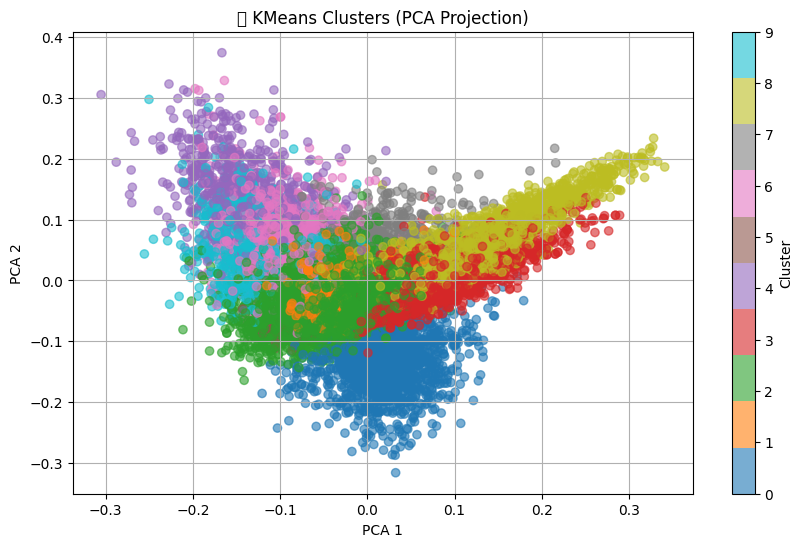

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensionality of TF-IDF features
pca = PCA(n_components=2, random_state=42)
reduced_data = pca.fit_transform(X_tfidf.toarray())

# Plot clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans_labels, cmap='tab10', alpha=0.6)
plt.title("📊 KMeans Clusters (PCA Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(scatter, label="Cluster")
plt.grid(True)
plt.show()


C:\Users\imran\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128273 (\N{KEY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


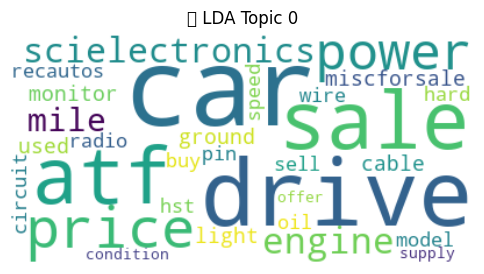

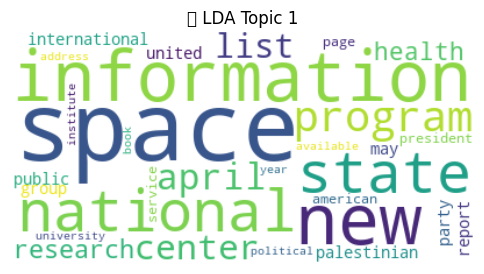

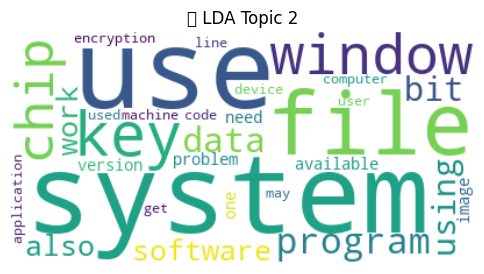

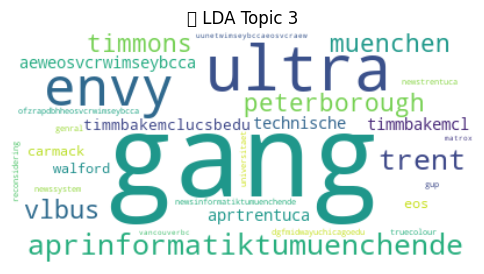

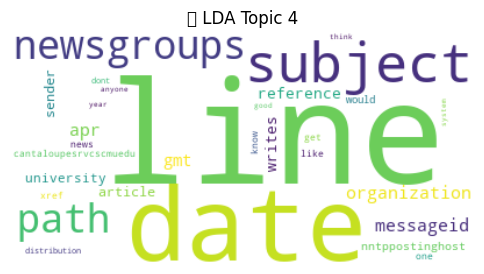

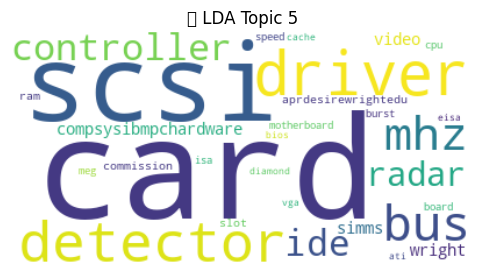

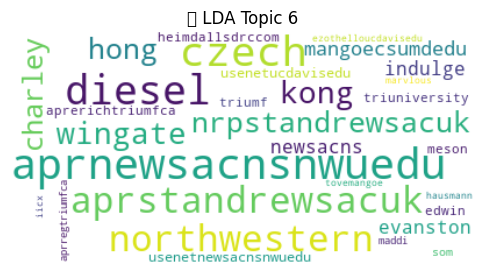

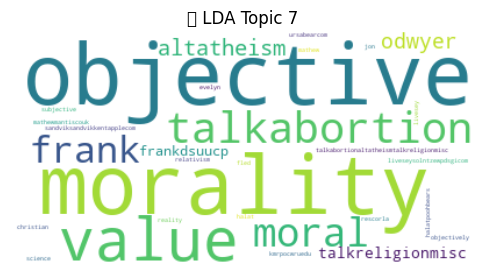

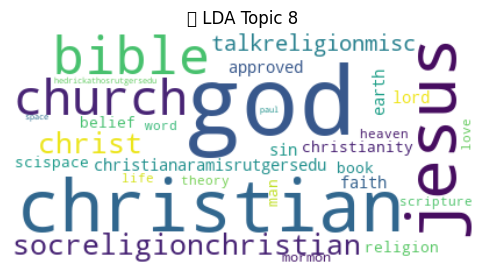

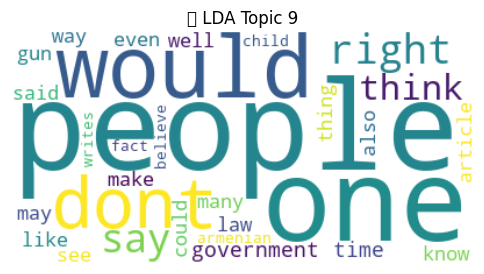

In [15]:
from wordcloud import WordCloud

# Create wordclouds for each LDA topic
for topic_id in range(num_topics):
    plt.figure(figsize=(6, 4))
    words = dict(lda_model.show_topic(topic_id, topn=30))
    wc = WordCloud(background_color="white", max_words=100).generate_from_frequencies(words)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"🔑 LDA Topic {topic_id}")
    plt.show()


C:\Users\imran\AppData\Local\Temp\ipykernel_10092\549732954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights, y=words, palette="viridis")


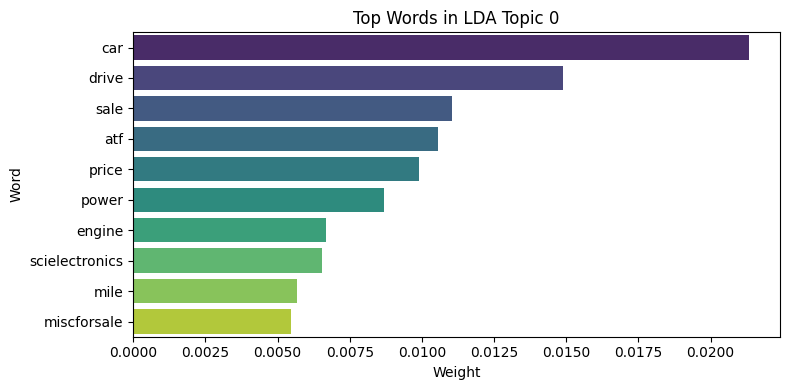

C:\Users\imran\AppData\Local\Temp\ipykernel_10092\549732954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights, y=words, palette="viridis")


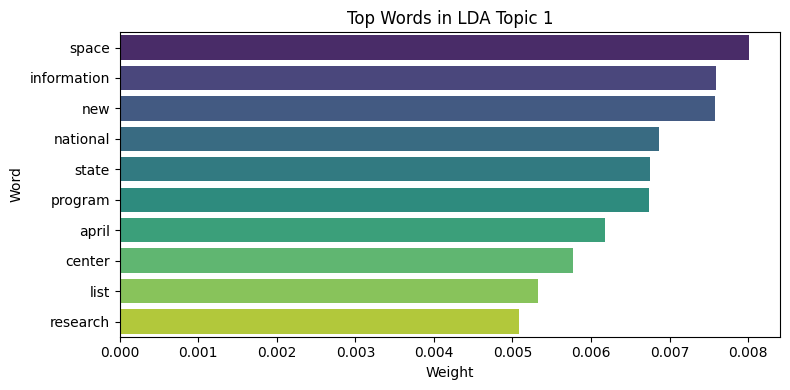

C:\Users\imran\AppData\Local\Temp\ipykernel_10092\549732954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights, y=words, palette="viridis")


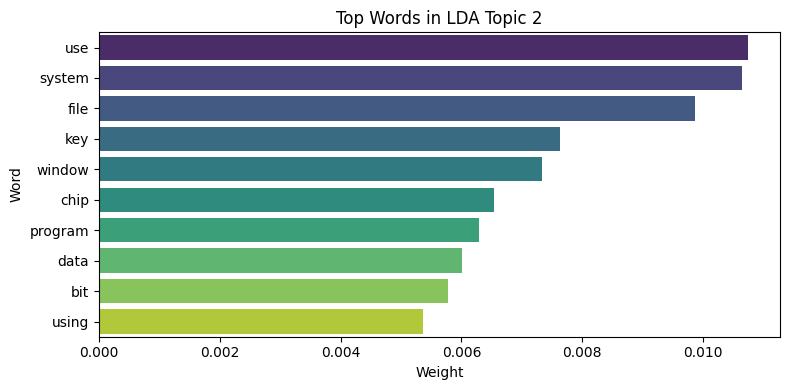

C:\Users\imran\AppData\Local\Temp\ipykernel_10092\549732954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights, y=words, palette="viridis")


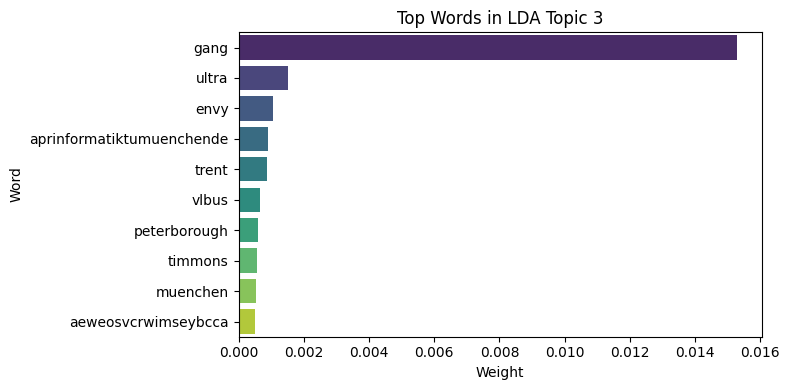

C:\Users\imran\AppData\Local\Temp\ipykernel_10092\549732954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights, y=words, palette="viridis")


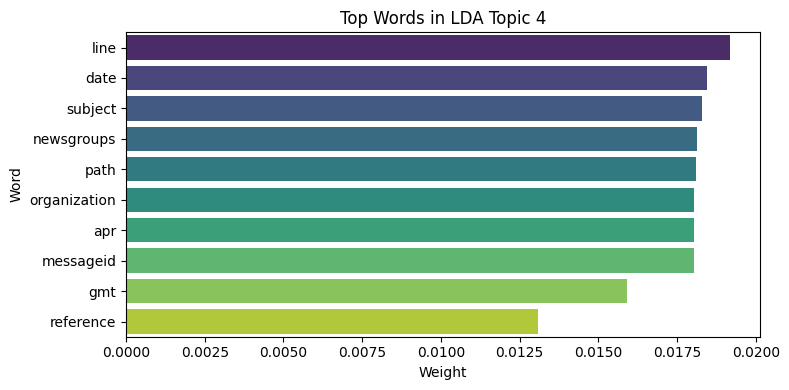

C:\Users\imran\AppData\Local\Temp\ipykernel_10092\549732954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights, y=words, palette="viridis")


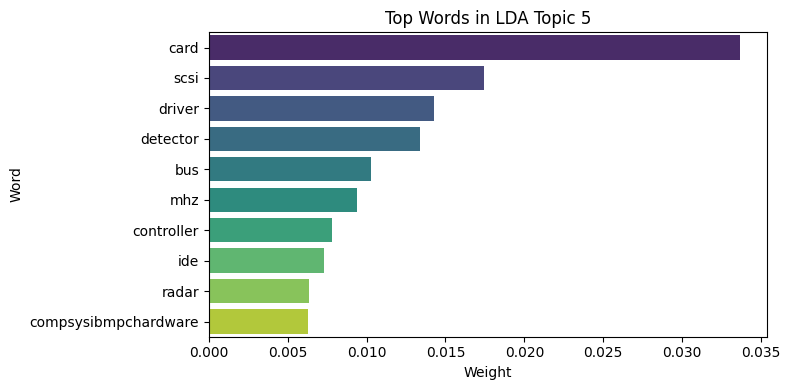

C:\Users\imran\AppData\Local\Temp\ipykernel_10092\549732954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights, y=words, palette="viridis")


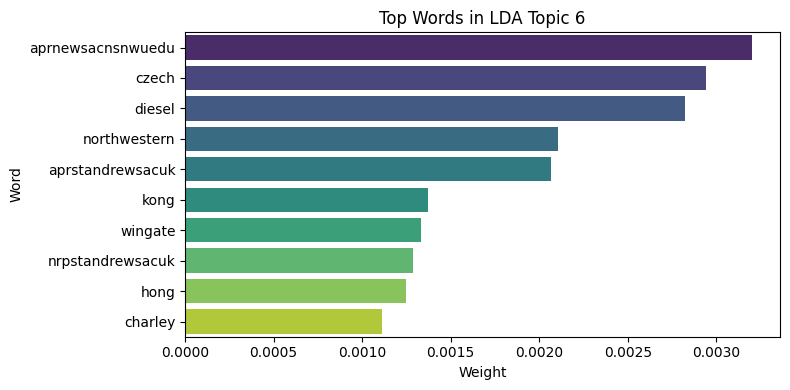

C:\Users\imran\AppData\Local\Temp\ipykernel_10092\549732954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights, y=words, palette="viridis")


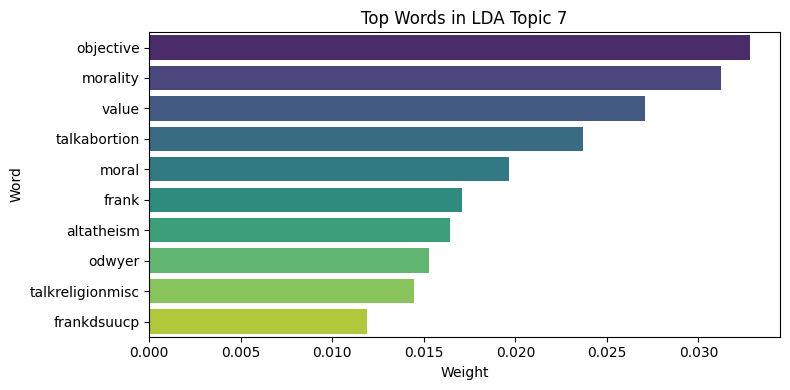

C:\Users\imran\AppData\Local\Temp\ipykernel_10092\549732954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights, y=words, palette="viridis")


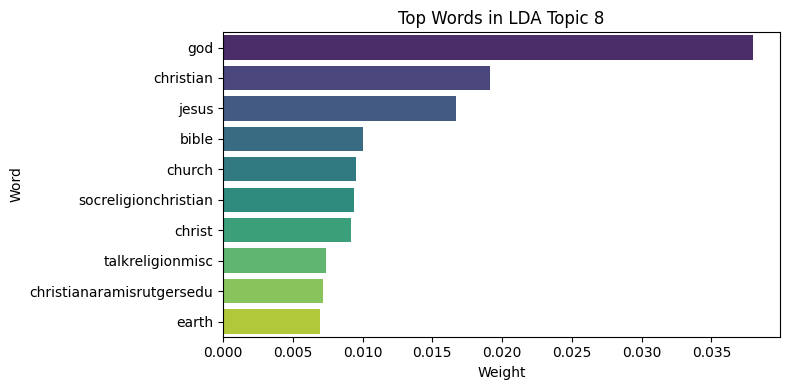

C:\Users\imran\AppData\Local\Temp\ipykernel_10092\549732954.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weights, y=words, palette="viridis")


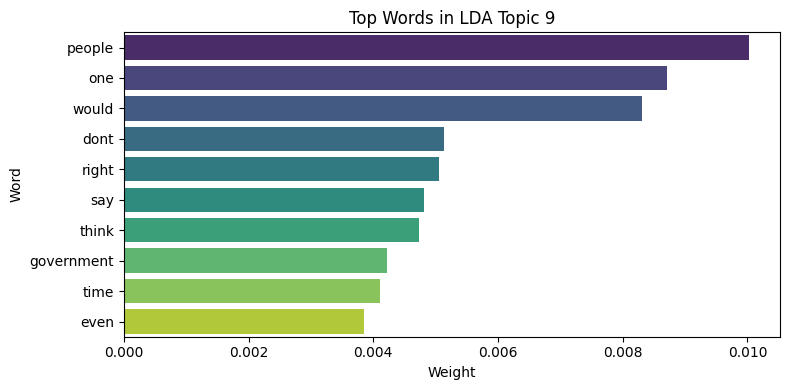

In [16]:
import seaborn as sns

# Show top 10 words in each topic with weights
for topic_id in range(num_topics):
    plt.figure(figsize=(8, 4))
    topic_words = lda_model.show_topic(topic_id, topn=10)
    words, weights = zip(*topic_words)
    sns.barplot(x=weights, y=words, palette="viridis")
    plt.title(f"Top Words in LDA Topic {topic_id}")
    plt.xlabel("Weight")
    plt.ylabel("Word")
    plt.tight_layout()
    plt.show()